In [9]:
from huggingface_hub import hf_hub_download
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from hyperopt import hp, tpe, fmin, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier

from preprocessing.utils import *

In [16]:
datasets = [
    'electricity.csv',
    'pol.csv',
    'covertype.csv',
    'MagicTelescope.csv',
    'Bioresponse.csv',
    'MiniBooNE.csv',
    'default-of-credit-card-clients.csv',
    'house_16H.csv',
    'Higgs.csv',
    'eye_movements.csv',
    'Diabetes130US.csv',
    'jannis.csv',
    'heloc.csv',
    'credit.csv',
    'california.csv'
]

REPO_ID = "inria-soda/tabular-benchmark"

In [17]:
for dataset in datasets:
    filename = "clf_num/" + dataset
    print(filename)

    df = pd.read_csv(
        hf_hub_download(repo_id=REPO_ID, filename=filename, repo_type="dataset")
    )
    print(df.head())

clf_num/electricity.csv
       date    period  nswprice  nswdemand  vicprice  vicdemand  transfer  \
0  0.898987  0.957447  0.068632   0.568283  0.004456   0.456499  0.644737   
1  0.867616  0.234043  0.033716   0.337102  0.001672   0.329622  0.846930   
2  0.009159  0.255319  0.059175   0.185808  0.003467   0.422915  0.414912   
3  0.898987  0.531915  0.087577   0.539572  0.004936   0.637752  0.491667   
4  0.868280  0.085106  0.027021   0.165129  0.001271   0.265924  0.748246   

  class  
0  DOWN  
1  DOWN  
2  DOWN  
3  DOWN  
4  DOWN  
clf_num/pol.csv
    f5   f6   f7  f8  f9  f13  f14  f15  f16  f17  ...  f25  f26  f27  f28  \
0  158  107   76  71  94    0    0   37   25    9  ...    0    0    0    0   
1  184   96   76  71  94    0   55   24   19   43  ...    0    0    0    0   
2   94  129   78  73  94    0   39   25    0    0  ...    0    0    2    0   
3   32  141   76  71  94    0    0    0    6    3  ...    0    0    0    0   
4   87   99  120  71  94    0   55   24    0   

In [20]:
def objective_function(hyperparameters):
    global iteration_n
    if iteration_n == 0:
        model = XGBClassifier()
    else :
        hyperparameters['max_depth'] = int(hyperparameters['max_depth'])
        hyperparameters['n_estimators'] = int(hyperparameters['n_estimators'])
        hyperparameters['min_child_weight'] = int(hyperparameters['min_child_weight'])
        model = XGBClassifier(**hyperparameters)
    iteration_n += 1
    # score = -np.mean(cross_val_score(model, train_data.iloc[:, :-1], train_data.iloc[:, -1], cv=5, scoring='accuracy'))
    model.fit(X_train, y_train)
    y_predict = model.predict(X_val)
    score = -accuracy_score(y_val, y_predict)

    return score

In [21]:
i = 0

filename = "clf_num/" + datasets[i]
df = pd.read_csv(
        hf_hub_download(repo_id=REPO_ID, filename=filename, repo_type="dataset")
)
print(df.head())

X, y = df.iloc[:, :-1], df.iloc[:, -1]
X, y = preprocess_data(X, y, isCategorical=True)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y, isCategorical=True)

# XGBoost
print('Running XGBoosting')
hyperparameter_space = {
    'max_depth': hp.uniformint('max_depth', 1, 11),
    'n_estimators': hp.quniform('n_estimators', 100, 6000, 200),
    'min_child_weight': hp.qloguniform('min_child_weight', np.log(1), np.log(1e2), 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(0.7)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(7)),
    'lambda': hp.loguniform('lambda', np.log(1), np.log(4)),
    'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1e2))
}

trials = Trials()
iteration_n = 0
best_hyperparameters = fmin(objective_function, hyperparameter_space, algo=tpe.suggest, max_evals=20, trials=trials)
scores_round = -1 * np.array(trials.losses())

with open(f'best_clf_cat_xgboost_params.pkl', 'wb') as f:
    pickle.dump(best_hyperparameters, f)
clf_num_xgboost_scores = scores_round.tolist()

       date    period  nswprice  nswdemand  vicprice  vicdemand  transfer  \
0  0.898987  0.957447  0.068632   0.568283  0.004456   0.456499  0.644737   
1  0.867616  0.234043  0.033716   0.337102  0.001672   0.329622  0.846930   
2  0.009159  0.255319  0.059175   0.185808  0.003467   0.422915  0.414912   
3  0.898987  0.531915  0.087577   0.539572  0.004936   0.637752  0.491667   
4  0.868280  0.085106  0.027021   0.165129  0.001271   0.265924  0.748246   

  class  
0  DOWN  
1  DOWN  
2  DOWN  
3  DOWN  
4  DOWN  
Removed 0 rows with missing values on 38474 rows
Removed 0 columns with missing values on 7 columns
Removed 0 rows with missing values on 38474 rows
Removed 0 columns with pseudo-categorical values on 7 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [00:37<00:00,  1.88s/trial, best loss: -0.8925476603119584]


Text(0, 0.5, 'Accuracy')

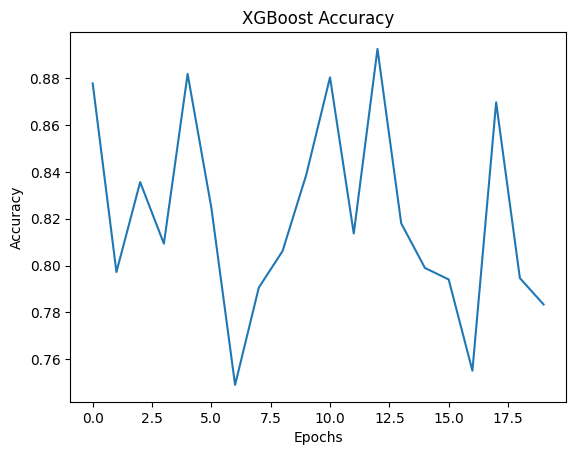

In [22]:
plt.plot(range(20), clf_num_xgboost_scores)
plt.title('XGBoost Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [23]:
best_hyperparameters

{'alpha': 1.2082790104065368e-07,
 'colsample_bylevel': 0.5013789166720986,
 'colsample_bytree': 0.9549160168983022,
 'gamma': 9.584294398100805e-06,
 'lambda': 1.1000648000801987,
 'learning_rate': 0.2988816312836514,
 'max_depth': 8.0,
 'min_child_weight': 2.0,
 'n_estimators': 400.0,
 'subsample': 0.9201373446517886}

In [24]:
trials.best_trial

{'state': 2,
 'tid': 12,
 'spec': None,
 'result': {'loss': -0.8925476603119584, 'status': 'ok'},
 'misc': {'tid': 12,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'alpha': [12],
   'colsample_bylevel': [12],
   'colsample_bytree': [12],
   'gamma': [12],
   'lambda': [12],
   'learning_rate': [12],
   'max_depth': [12],
   'min_child_weight': [12],
   'n_estimators': [12],
   'subsample': [12]},
  'vals': {'alpha': [1.2082790104065368e-07],
   'colsample_bylevel': [0.5013789166720986],
   'colsample_bytree': [0.9549160168983022],
   'gamma': [9.584294398100805e-06],
   'lambda': [1.1000648000801987],
   'learning_rate': [0.2988816312836514],
   'max_depth': [8.0],
   'min_child_weight': [2.0],
   'n_estimators': [400.0],
   'subsample': [0.9201373446517886]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 5, 20, 19, 58, 7, 504000),
 'refresh_time': datetime.datetime(2024, 5, 20, 19, 58, 8, 115000)}

In [28]:
def plot_graph(clf_num_xgboost_scores):
    plt.plot(range(20), clf_num_xgboost_scores)
    plt.title('XGBoost Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [27]:
import time
display("hello")

'hello'

running: clf_num/electricity.csv
Removed 0 rows with missing values on 38474 rows
Removed 0 columns with missing values on 7 columns
Removed 0 rows with missing values on 38474 rows
Removed 0 columns with pseudo-categorical values on 7 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.33s/trial, best loss: -0.892836510687464]


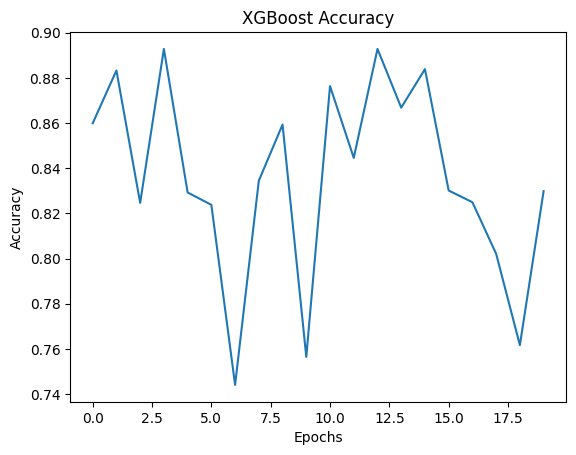

"best hyperparameters:{'alpha': 0.00017233091169222331, 'colsample_bylevel': 0.7182225953470595, 'colsample_bytree': 0.7557637742307242, 'gamma': 6.93042304835411e-05, 'lambda': 3.236164000453018, 'learning_rate': 0.05993196442282784, 'max_depth': 11.0, 'min_child_weight': 5.0, 'n_estimators': 2000.0, 'subsample': 0.9928405395355617}"

"best trial: {'state': 2, 'tid': 3, 'spec': None, 'result': {'loss': -0.892836510687464, 'status': 'ok'}, 'misc': {'tid': 3, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [3], 'colsample_bylevel': [3], 'colsample_bytree': [3], 'gamma': [3], 'lambda': [3], 'learning_rate': [3], 'max_depth': [3], 'min_child_weight': [3], 'n_estimators': [3], 'subsample': [3]}, 'vals': {'alpha': [0.00017233091169222331], 'colsample_bylevel': [0.7182225953470595], 'colsample_bytree': [0.7557637742307242], 'gamma': [6.93042304835411e-05], 'lambda': [3.236164000453018], 'learning_rate': [0.05993196442282784], 'max_depth': [11.0], 'min_child_weight': [5.0], 'n_estimators': [2000.0], 'subsample': [0.9928405395355617]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 18, 48, 315000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 18, 50, 905000)}"

running: clf_num/pol.csv
Removed 0 rows with missing values on 10082 rows
Removed 0 columns with missing values on 26 columns
Removed 0 rows with missing values on 10082 rows
Removed 0 columns with pseudo-categorical values on 26 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [00:49<00:00,  2.48s/trial, best loss: -0.8913922588099364]


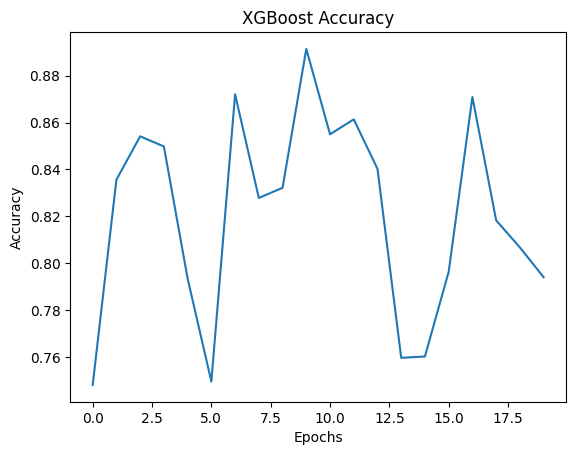

"best hyperparameters:{'alpha': 0.011373518329234862, 'colsample_bylevel': 0.7300680578446708, 'colsample_bytree': 0.8578984680312622, 'gamma': 5.8478563488389045e-05, 'lambda': 1.241817324829481, 'learning_rate': 0.4579303303660532, 'max_depth': 7.0, 'min_child_weight': 4.0, 'n_estimators': 5400.0, 'subsample': 0.9964585100931997}"

"best trial: {'state': 2, 'tid': 9, 'spec': None, 'result': {'loss': -0.8913922588099364, 'status': 'ok'}, 'misc': {'tid': 9, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [9], 'colsample_bylevel': [9], 'colsample_bytree': [9], 'gamma': [9], 'lambda': [9], 'learning_rate': [9], 'max_depth': [9], 'min_child_weight': [9], 'n_estimators': [9], 'subsample': [9]}, 'vals': {'alpha': [0.011373518329234862], 'colsample_bylevel': [0.7300680578446708], 'colsample_bytree': [0.8578984680312622], 'gamma': [5.8478563488389045e-05], 'lambda': [1.241817324829481], 'learning_rate': [0.4579303303660532], 'max_depth': [7.0], 'min_child_weight': [4.0], 'n_estimators': [5400.0], 'subsample': [0.9964585100931997]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 19, 46, 920000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 19, 51, 872000)}"

running: clf_num/covertype.csv
Removed 0 rows with missing values on 566602 rows
Removed 0 columns with missing values on 10 columns
Removed 0 rows with missing values on 566602 rows
Removed 0 columns with pseudo-categorical values on 10 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [00:52<00:00,  2.60s/trial, best loss: -0.8902368573079145]


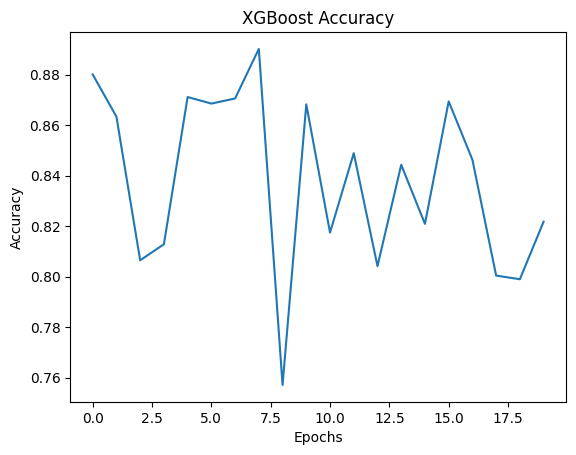

"best hyperparameters:{'alpha': 0.004749643550362547, 'colsample_bylevel': 0.6572270055639848, 'colsample_bytree': 0.9481972315840932, 'gamma': 0.21608208482444946, 'lambda': 3.294367245270426, 'learning_rate': 0.022730990374089474, 'max_depth': 9.0, 'min_child_weight': 1.0, 'n_estimators': 3400.0, 'subsample': 0.8568895617442747}"

"best trial: {'state': 2, 'tid': 7, 'spec': None, 'result': {'loss': -0.8902368573079145, 'status': 'ok'}, 'misc': {'tid': 7, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [7], 'colsample_bylevel': [7], 'colsample_bytree': [7], 'gamma': [7], 'lambda': [7], 'learning_rate': [7], 'max_depth': [7], 'min_child_weight': [7], 'n_estimators': [7], 'subsample': [7]}, 'vals': {'alpha': [0.004749643550362547], 'colsample_bylevel': [0.6572270055639848], 'colsample_bytree': [0.9481972315840932], 'gamma': [0.21608208482444946], 'lambda': [3.294367245270426], 'learning_rate': [0.022730990374089474], 'max_depth': [9.0], 'min_child_weight': [1.0], 'n_estimators': [3400.0], 'subsample': [0.8568895617442747]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 20, 40, 664000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 20, 45, 127000)}"

running: clf_num/MagicTelescope.csv
Removed 0 rows with missing values on 13376 rows
Removed 0 columns with missing values on 10 columns
Removed 0 rows with missing values on 13376 rows
Removed 0 columns with pseudo-categorical values on 10 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [01:01<00:00,  3.10s/trial, best loss: -0.8913922588099364]


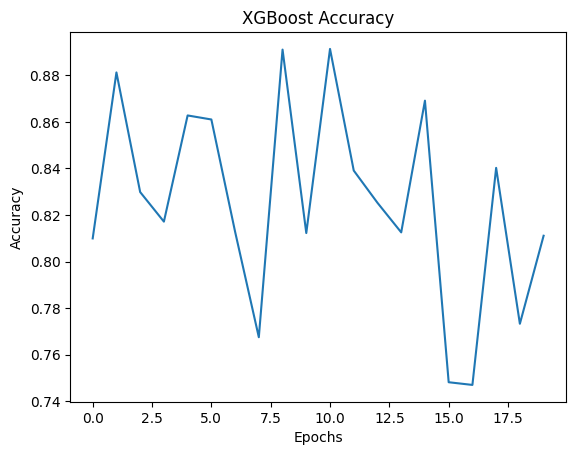

"best hyperparameters:{'alpha': 4.4320781548804934e-07, 'colsample_bylevel': 0.9201436314403639, 'colsample_bytree': 0.6773638105183675, 'gamma': 6.986181180644266e-08, 'lambda': 2.8278999965588074, 'learning_rate': 0.3978936095584832, 'max_depth': 11.0, 'min_child_weight': 3.0, 'n_estimators': 600.0, 'subsample': 0.9065015400451855}"

"best trial: {'state': 2, 'tid': 10, 'spec': None, 'result': {'loss': -0.8913922588099364, 'status': 'ok'}, 'misc': {'tid': 10, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [10], 'colsample_bylevel': [10], 'colsample_bytree': [10], 'gamma': [10], 'lambda': [10], 'learning_rate': [10], 'max_depth': [10], 'min_child_weight': [10], 'n_estimators': [10], 'subsample': [10]}, 'vals': {'alpha': [4.4320781548804934e-07], 'colsample_bylevel': [0.9201436314403639], 'colsample_bytree': [0.6773638105183675], 'gamma': [6.986181180644266e-08], 'lambda': [2.8278999965588074], 'learning_rate': [0.3978936095584832], 'max_depth': [11.0], 'min_child_weight': [3.0], 'n_estimators': [600.0], 'subsample': [0.9065015400451855]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 21, 56, 392000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 21, 57, 672000)}"

running: clf_num/Bioresponse.csv
Removed 0 rows with missing values on 3434 rows
Removed 0 columns with missing values on 419 columns
Removed 0 rows with missing values on 3434 rows
Removed 8 columns with pseudo-categorical values on 419 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [00:51<00:00,  2.59s/trial, best loss: -0.8853264009243212]


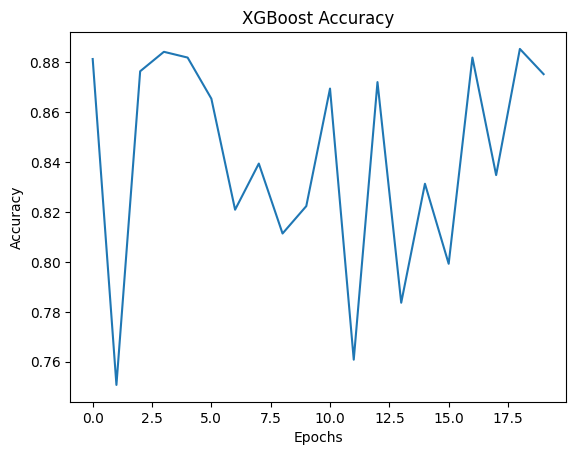

"best hyperparameters:{'alpha': 0.0019222094717090434, 'colsample_bylevel': 0.5633443291496881, 'colsample_bytree': 0.9021048080439098, 'gamma': 0.000677520004762133, 'lambda': 2.634477404022095, 'learning_rate': 0.2613989262857004, 'max_depth': 10.0, 'min_child_weight': 13.0, 'n_estimators': 400.0, 'subsample': 0.9202507128554831}"

"best trial: {'state': 2, 'tid': 18, 'spec': None, 'result': {'loss': -0.8853264009243212, 'status': 'ok'}, 'misc': {'tid': 18, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [18], 'colsample_bylevel': [18], 'colsample_bytree': [18], 'gamma': [18], 'lambda': [18], 'learning_rate': [18], 'max_depth': [18], 'min_child_weight': [18], 'n_estimators': [18], 'subsample': [18]}, 'vals': {'alpha': [0.0019222094717090434], 'colsample_bylevel': [0.5633443291496881], 'colsample_bytree': [0.9021048080439098], 'gamma': [0.000677520004762133], 'lambda': [2.634477404022095], 'learning_rate': [0.2613989262857004], 'max_depth': [10.0], 'min_child_weight': [13.0], 'n_estimators': [400.0], 'subsample': [0.9202507128554831]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 23, 10, 2000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 23, 10, 582000)}"

running: clf_num/MiniBooNE.csv
Removed 0 rows with missing values on 72998 rows
Removed 0 columns with missing values on 50 columns
Removed 0 rows with missing values on 72998 rows
Removed 0 columns with pseudo-categorical values on 50 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [01:01<00:00,  3.05s/trial, best loss: -0.8867706528018486]


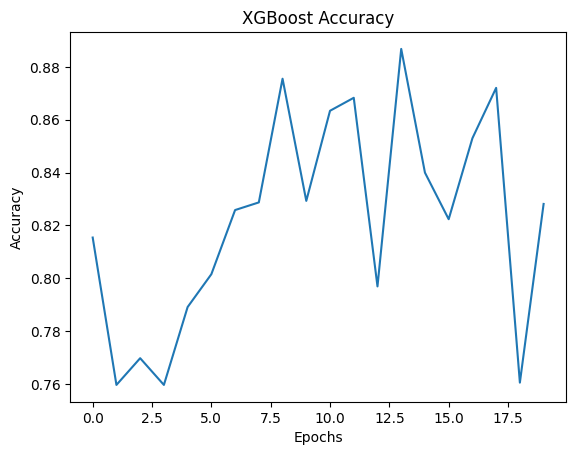

"best hyperparameters:{'alpha': 3.7073406903360136e-08, 'colsample_bylevel': 0.9788692222455442, 'colsample_bytree': 0.8498345275115706, 'gamma': 0.00034547420378874935, 'lambda': 2.378871228982227, 'learning_rate': 0.05134587888888059, 'max_depth': 10.0, 'min_child_weight': 4.0, 'n_estimators': 600.0, 'subsample': 0.7842279905271445}"

"best trial: {'state': 2, 'tid': 13, 'spec': None, 'result': {'loss': -0.8867706528018486, 'status': 'ok'}, 'misc': {'tid': 13, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [13], 'colsample_bylevel': [13], 'colsample_bytree': [13], 'gamma': [13], 'lambda': [13], 'learning_rate': [13], 'max_depth': [13], 'min_child_weight': [13], 'n_estimators': [13], 'subsample': [13]}, 'vals': {'alpha': [3.7073406903360136e-08], 'colsample_bylevel': [0.9788692222455442], 'colsample_bytree': [0.8498345275115706], 'gamma': [0.00034547420378874935], 'lambda': [2.378871228982227], 'learning_rate': [0.05134587888888059], 'max_depth': [10.0], 'min_child_weight': [4.0], 'n_estimators': [600.0], 'subsample': [0.7842279905271445]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 23, 55, 887000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 23, 56, 925000)}"

running: clf_num/default-of-credit-card-clients.csv
Removed 0 rows with missing values on 13272 rows
Removed 0 columns with missing values on 20 columns
Removed 0 rows with missing values on 13272 rows
Removed 0 columns with pseudo-categorical values on 20 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [01:03<00:00,  3.15s/trial, best loss: -0.8913922588099364]


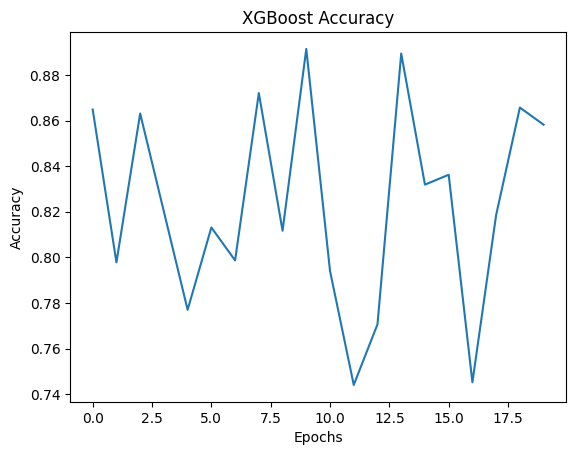

"best hyperparameters:{'alpha': 1.609505729006412e-05, 'colsample_bylevel': 0.7375858660105583, 'colsample_bytree': 0.8879192777000227, 'gamma': 0.0013671511145630503, 'lambda': 1.8365471302216403, 'learning_rate': 0.05765835545739899, 'max_depth': 7.0, 'min_child_weight': 6.0, 'n_estimators': 2200.0, 'subsample': 0.7412256139904505}"

"best trial: {'state': 2, 'tid': 9, 'spec': None, 'result': {'loss': -0.8913922588099364, 'status': 'ok'}, 'misc': {'tid': 9, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [9], 'colsample_bylevel': [9], 'colsample_bytree': [9], 'gamma': [9], 'lambda': [9], 'learning_rate': [9], 'max_depth': [9], 'min_child_weight': [9], 'n_estimators': [9], 'subsample': [9]}, 'vals': {'alpha': [1.609505729006412e-05], 'colsample_bylevel': [0.7375858660105583], 'colsample_bytree': [0.8879192777000227], 'gamma': [0.0013671511145630503], 'lambda': [1.8365471302216403], 'learning_rate': [0.05765835545739899], 'max_depth': [7.0], 'min_child_weight': [6.0], 'n_estimators': [2200.0], 'subsample': [0.7412256139904505]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 24, 53, 467000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 24, 56, 162000)}"

running: clf_num/house_16H.csv
Removed 0 rows with missing values on 13488 rows
Removed 0 columns with missing values on 16 columns
Removed 0 rows with missing values on 13488 rows
Removed 0 columns with pseudo-categorical values on 16 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [00:56<00:00,  2.82s/trial, best loss: -0.8789716926632004]


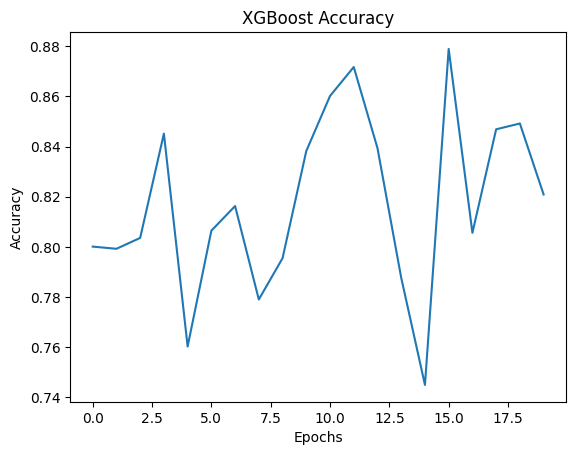

"best hyperparameters:{'alpha': 5.006498675505771e-05, 'colsample_bylevel': 0.6626466217582887, 'colsample_bytree': 0.7860814400072236, 'gamma': 0.0014105865120492154, 'lambda': 1.7727146204984894, 'learning_rate': 0.3203617687959463, 'max_depth': 11.0, 'min_child_weight': 15.0, 'n_estimators': 3400.0, 'subsample': 0.7469844636610058}"

"best trial: {'state': 2, 'tid': 15, 'spec': None, 'result': {'loss': -0.8789716926632004, 'status': 'ok'}, 'misc': {'tid': 15, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [15], 'colsample_bylevel': [15], 'colsample_bytree': [15], 'gamma': [15], 'lambda': [15], 'learning_rate': [15], 'max_depth': [15], 'min_child_weight': [15], 'n_estimators': [15], 'subsample': [15]}, 'vals': {'alpha': [5.006498675505771e-05], 'colsample_bylevel': [0.6626466217582887], 'colsample_bytree': [0.7860814400072236], 'gamma': [0.0014105865120492154], 'lambda': [1.7727146204984894], 'learning_rate': [0.3203617687959463], 'max_depth': [11.0], 'min_child_weight': [15.0], 'n_estimators': [3400.0], 'subsample': [0.7469844636610058]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 26, 19, 431000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 26, 23, 959000)}"

running: clf_num/Higgs.csv
Removed 0 rows with missing values on 940160 rows
Removed 0 columns with missing values on 24 columns
Removed 0 rows with missing values on 940160 rows
Removed 0 columns with pseudo-categorical values on 24 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [01:04<00:00,  3.20s/trial, best loss: -0.8885037550548815]


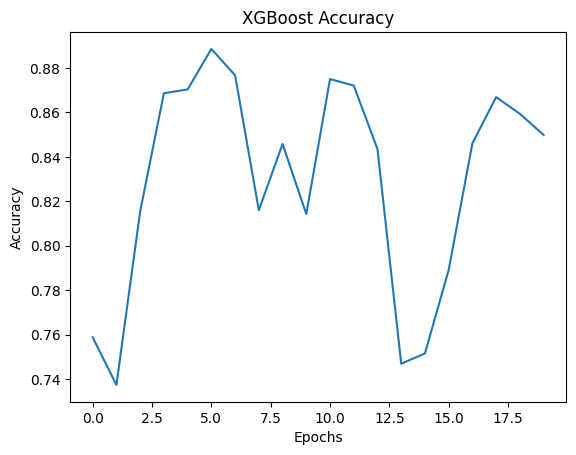

"best hyperparameters:{'alpha': 0.01028331369715677, 'colsample_bylevel': 0.6781060000961896, 'colsample_bytree': 0.9010240254137356, 'gamma': 0.005131673687262691, 'lambda': 1.6464772057022112, 'learning_rate': 0.4263504432730836, 'max_depth': 5.0, 'min_child_weight': 5.0, 'n_estimators': 2800.0, 'subsample': 0.8899329753712485}"

"best trial: {'state': 2, 'tid': 5, 'spec': None, 'result': {'loss': -0.8885037550548815, 'status': 'ok'}, 'misc': {'tid': 5, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [5], 'colsample_bylevel': [5], 'colsample_bytree': [5], 'gamma': [5], 'lambda': [5], 'learning_rate': [5], 'max_depth': [5], 'min_child_weight': [5], 'n_estimators': [5], 'subsample': [5]}, 'vals': {'alpha': [0.01028331369715677], 'colsample_bylevel': [0.6781060000961896], 'colsample_bytree': [0.9010240254137356], 'gamma': [0.005131673687262691], 'lambda': [1.6464772057022112], 'learning_rate': [0.4263504432730836], 'max_depth': [5.0], 'min_child_weight': [5.0], 'n_estimators': [2800.0], 'subsample': [0.8899329753712485]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 26, 54, 80000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 26, 56, 956000)}"

running: clf_num/eye_movements.csv
Removed 0 rows with missing values on 7608 rows
Removed 0 columns with missing values on 20 columns
Removed 0 rows with missing values on 7608 rows
Removed 0 columns with pseudo-categorical values on 20 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [00:57<00:00,  2.89s/trial, best loss: -0.8911034084344309]


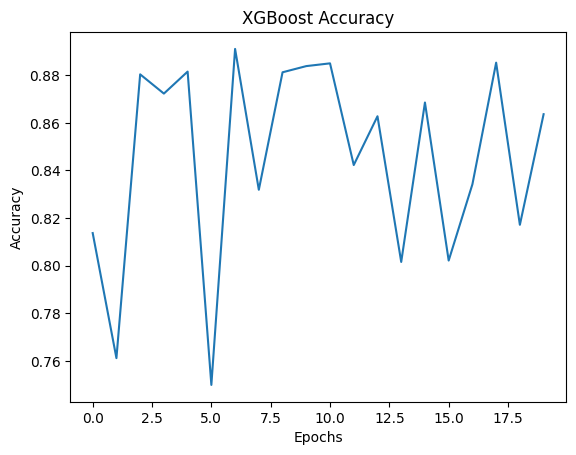

"best hyperparameters:{'alpha': 0.01635311742606475, 'colsample_bylevel': 0.8818916151587602, 'colsample_bytree': 0.9231753603751491, 'gamma': 5.007612294620647e-05, 'lambda': 3.854419618503654, 'learning_rate': 0.3990948083125098, 'max_depth': 10.0, 'min_child_weight': 1.0, 'n_estimators': 1200.0, 'subsample': 0.9124693873499159}"

"best trial: {'state': 2, 'tid': 6, 'spec': None, 'result': {'loss': -0.8911034084344309, 'status': 'ok'}, 'misc': {'tid': 6, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [6], 'colsample_bylevel': [6], 'colsample_bytree': [6], 'gamma': [6], 'lambda': [6], 'learning_rate': [6], 'max_depth': [6], 'min_child_weight': [6], 'n_estimators': [6], 'subsample': [6]}, 'vals': {'alpha': [0.01635311742606475], 'colsample_bylevel': [0.8818916151587602], 'colsample_bytree': [0.9231753603751491], 'gamma': [5.007612294620647e-05], 'lambda': [3.854419618503654], 'learning_rate': [0.3990948083125098], 'max_depth': [10.0], 'min_child_weight': [1.0], 'n_estimators': [1200.0], 'subsample': [0.9124693873499159]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 28, 1, 778000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 28, 3, 973000)}"

running: clf_num/Diabetes130US.csv
Removed 0 rows with missing values on 71090 rows
Removed 0 columns with missing values on 7 columns
Removed 0 rows with missing values on 71090 rows
Removed 0 columns with pseudo-categorical values on 7 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [00:55<00:00,  2.76s/trial, best loss: -0.8873483535528596]


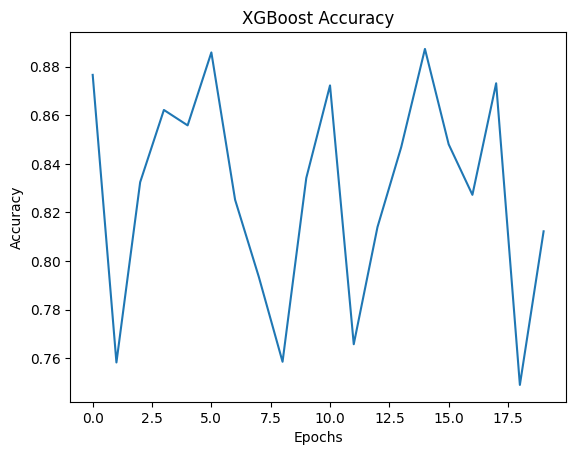

"best hyperparameters:{'alpha': 2.2616583957511563e-06, 'colsample_bylevel': 0.9373609235692593, 'colsample_bytree': 0.7889751559947911, 'gamma': 5.615966856862319e-05, 'lambda': 1.5878327142402462, 'learning_rate': 0.3853334161168857, 'max_depth': 6.0, 'min_child_weight': 2.0, 'n_estimators': 600.0, 'subsample': 0.8430754270420472}"

"best trial: {'state': 2, 'tid': 14, 'spec': None, 'result': {'loss': -0.8873483535528596, 'status': 'ok'}, 'misc': {'tid': 14, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [14], 'colsample_bylevel': [14], 'colsample_bytree': [14], 'gamma': [14], 'lambda': [14], 'learning_rate': [14], 'max_depth': [14], 'min_child_weight': [14], 'n_estimators': [14], 'subsample': [14]}, 'vals': {'alpha': [2.2616583957511563e-06], 'colsample_bylevel': [0.9373609235692593], 'colsample_bytree': [0.7889751559947911], 'gamma': [5.615966856862319e-05], 'lambda': [1.5878327142402462], 'learning_rate': [0.3853334161168857], 'max_depth': [6.0], 'min_child_weight': [2.0], 'n_estimators': [600.0], 'subsample': [0.8430754270420472]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 29, 24, 315000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 29, 25, 93000)}"

running: clf_num/jannis.csv
Removed 0 rows with missing values on 57580 rows
Removed 0 columns with missing values on 54 columns
Removed 0 rows with missing values on 57580 rows
Removed 0 columns with pseudo-categorical values on 54 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [01:07<00:00,  3.37s/trial, best loss: -0.8766608896591566]


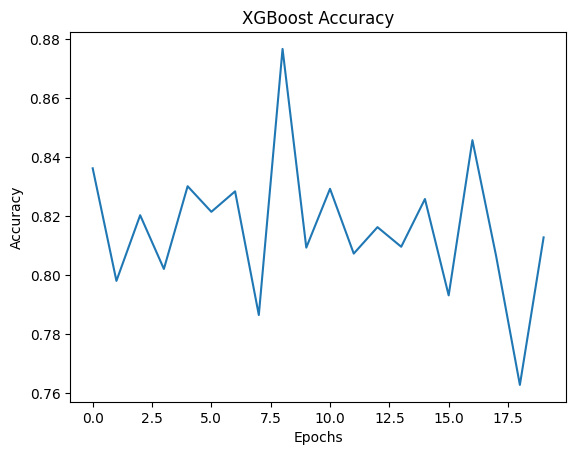

"best hyperparameters:{'alpha': 0.0241064723593234, 'colsample_bylevel': 0.6827245408960003, 'colsample_bytree': 0.553590193672524, 'gamma': 0.0005435866200665342, 'lambda': 2.5883525058033046, 'learning_rate': 0.44984300101205393, 'max_depth': 10.0, 'min_child_weight': 4.0, 'n_estimators': 1800.0, 'subsample': 0.6547673606235709}"

"best trial: {'state': 2, 'tid': 8, 'spec': None, 'result': {'loss': -0.8766608896591566, 'status': 'ok'}, 'misc': {'tid': 8, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [8], 'colsample_bylevel': [8], 'colsample_bytree': [8], 'gamma': [8], 'lambda': [8], 'learning_rate': [8], 'max_depth': [8], 'min_child_weight': [8], 'n_estimators': [8], 'subsample': [8]}, 'vals': {'alpha': [0.0241064723593234], 'colsample_bylevel': [0.6827245408960003], 'colsample_bytree': [0.553590193672524], 'gamma': [0.0005435866200665342], 'lambda': [2.5883525058033046], 'learning_rate': [0.44984300101205393], 'max_depth': [10.0], 'min_child_weight': [4.0], 'n_estimators': [1800.0], 'subsample': [0.6547673606235709]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 29, 55, 842000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 29, 58, 205000)}"

running: clf_num/heloc.csv
Removed 0 rows with missing values on 10000 rows
Removed 0 columns with missing values on 22 columns
Removed 0 rows with missing values on 10000 rows
Removed 0 columns with pseudo-categorical values on 22 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|████████████████████████████████████████████████| 20/20 [01:01<00:00,  3.05s/trial, best loss: -0.889948006932409]


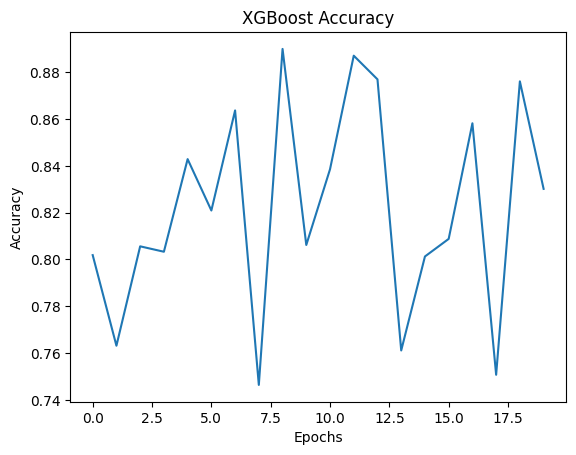

"best hyperparameters:{'alpha': 2.4454107110401035e-06, 'colsample_bylevel': 0.7530790219482688, 'colsample_bytree': 0.6693245338851768, 'gamma': 3.1159580454755734e-07, 'lambda': 1.5025255574400467, 'learning_rate': 0.0970026551295508, 'max_depth': 6.0, 'min_child_weight': 2.0, 'n_estimators': 5800.0, 'subsample': 0.7970501891673132}"

"best trial: {'state': 2, 'tid': 8, 'spec': None, 'result': {'loss': -0.889948006932409, 'status': 'ok'}, 'misc': {'tid': 8, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [8], 'colsample_bylevel': [8], 'colsample_bytree': [8], 'gamma': [8], 'lambda': [8], 'learning_rate': [8], 'max_depth': [8], 'min_child_weight': [8], 'n_estimators': [8], 'subsample': [8]}, 'vals': {'alpha': [2.4454107110401035e-06], 'colsample_bylevel': [0.7530790219482688], 'colsample_bytree': [0.6693245338851768], 'gamma': [3.1159580454755734e-07], 'lambda': [1.5025255574400467], 'learning_rate': [0.0970026551295508], 'max_depth': [6.0], 'min_child_weight': [2.0], 'n_estimators': [5800.0], 'subsample': [0.7970501891673132]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 31, 10, 462000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 31, 15, 912000)}"

running: clf_num/credit.csv
Removed 0 rows with missing values on 16714 rows
Removed 0 columns with missing values on 10 columns
Removed 0 rows with missing values on 16714 rows
Removed 1 columns with pseudo-categorical values on 10 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [00:59<00:00,  2.96s/trial, best loss: -0.8824378971692663]


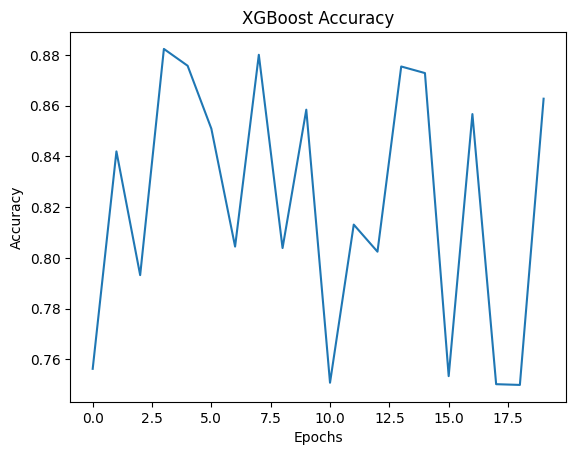

"best hyperparameters:{'alpha': 0.25857646134074364, 'colsample_bylevel': 0.9961503479374862, 'colsample_bytree': 0.5448055053189054, 'gamma': 5.152931478318839e-05, 'lambda': 1.1037968547197596, 'learning_rate': 0.020354400488371446, 'max_depth': 7.0, 'min_child_weight': 1.0, 'n_estimators': 3800.0, 'subsample': 0.9199833425221398}"

"best trial: {'state': 2, 'tid': 3, 'spec': None, 'result': {'loss': -0.8824378971692663, 'status': 'ok'}, 'misc': {'tid': 3, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [3], 'colsample_bylevel': [3], 'colsample_bytree': [3], 'gamma': [3], 'lambda': [3], 'learning_rate': [3], 'max_depth': [3], 'min_child_weight': [3], 'n_estimators': [3], 'subsample': [3]}, 'vals': {'alpha': [0.25857646134074364], 'colsample_bylevel': [0.9961503479374862], 'colsample_bytree': [0.5448055053189054], 'gamma': [5.152931478318839e-05], 'lambda': [1.1037968547197596], 'learning_rate': [0.020354400488371446], 'max_depth': [7.0], 'min_child_weight': [1.0], 'n_estimators': [3800.0], 'subsample': [0.9199833425221398]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 32, 12, 53000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 32, 17, 352000)}"

running: clf_num/california.csv
Removed 0 rows with missing values on 20634 rows
Removed 0 columns with missing values on 8 columns
Removed 0 rows with missing values on 20634 rows
Removed 0 columns with pseudo-categorical values on 8 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Running XGBoosting
100%|███████████████████████████████████████████████| 20/20 [00:52<00:00,  2.62s/trial, best loss: -0.8890814558058926]


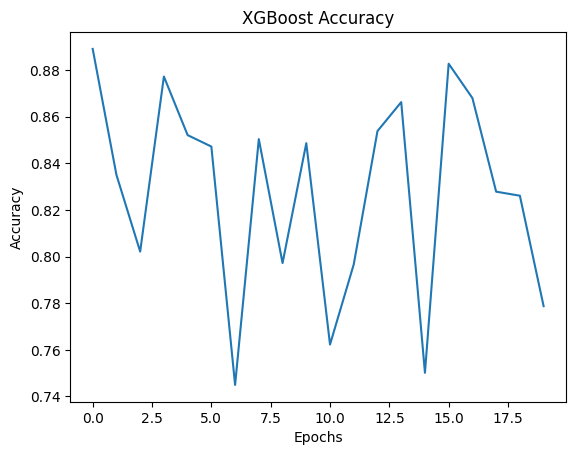

"best hyperparameters:{'alpha': 1.3494953431881496e-08, 'colsample_bylevel': 0.8109805234943495, 'colsample_bytree': 0.554251516534521, 'gamma': 0.0018997526929005097, 'lambda': 2.6176314991619254, 'learning_rate': 0.034230830124519336, 'max_depth': 9.0, 'min_child_weight': 1.0, 'n_estimators': 2000.0, 'subsample': 0.9700295026382952}"

"best trial: {'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': -0.8890814558058926, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': [0], 'colsample_bylevel': [0], 'colsample_bytree': [0], 'gamma': [0], 'lambda': [0], 'learning_rate': [0], 'max_depth': [0], 'min_child_weight': [0], 'n_estimators': [0], 'subsample': [0]}, 'vals': {'alpha': [1.3494953431881496e-08], 'colsample_bylevel': [0.8109805234943495], 'colsample_bytree': [0.554251516534521], 'gamma': [0.0018997526929005097], 'lambda': [2.6176314991619254], 'learning_rate': [0.034230830124519336], 'max_depth': [9.0], 'min_child_weight': [1.0], 'n_estimators': [2000.0], 'subsample': [0.9700295026382952]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 20, 20, 32, 58, 302000), 'refresh_time': datetime.datetime(2024, 5, 20, 20, 33, 1, 257000)}"

In [29]:
def train_xg_boost(df):
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    X, y = preprocess_data(X, y, isCategorical=True)
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y, isCategorical=True)

    # XGBoost
    print('Running XGBoosting')
    hyperparameter_space = {
        'max_depth': hp.uniformint('max_depth', 1, 11),
        'n_estimators': hp.quniform('n_estimators', 100, 6000, 200),
        'min_child_weight': hp.qloguniform('min_child_weight', np.log(1), np.log(1e2), 1),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(0.7)),
        'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(7)),
        'lambda': hp.loguniform('lambda', np.log(1), np.log(4)),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1e2))
    }

    trials = Trials()
    iteration_n = 0
    best_hyperparameters = fmin(objective_function, hyperparameter_space, algo=tpe.suggest, max_evals=20, trials=trials)
    scores_round = -1 * np.array(trials.losses())

    with open(f'best_clf_cat_xgboost_params.pkl', 'wb') as f:
        pickle.dump(best_hyperparameters, f)
        clf_num_xgboost_scores = scores_round.tolist()

    plot_graph(clf_num_xgboost_scores)
    display('best hyperparameters:' + str(best_hyperparameters))
    display('best trial: ' + str(trials.best_trial))
    

for dataset in datasets:
    filename = "clf_num/" + dataset
    df = pd.read_csv(
        hf_hub_download(repo_id=REPO_ID, filename=filename, repo_type="dataset")
    )

    print("running: " + filename)
    train_xg_boost(df)
    time.sleep(2)
